# This is a Jupyter notebook for CE888 Assignment 1 - Imbalanced Datasets
In this notebook, we will load three balanced datasets, unbalance them by resampling the the classes and test a new approach to dealing with imbalanced datasets.

# Step 1: Load the necessary libraries

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

# Step 2: Load the datasets

###df1: Heart Disease UCI

Downloaded from Kaggle

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

###df2: Brain Tumor Dataset

Downloaded from Kaggle

This is a brain tumor feature dataset including five first-order features and eight texture features with the target level (in the column Class).
Image column defines image name and Class column defines either the image has tumor or not (1 = Tumor, 0 = Non-Tumor)

###df3: Diabetes Health Indicators Dataset

Downloaded from Kaggle

This is a clean dataset of 70,692 survey responses to the CDC's BRFSS2015. It has an equal 50-50 split of respondents with no diabetes and with either prediabetes or diabetes. The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes. This dataset has 21 feature variables and is balanced.



In [2]:
df1 = pd.read_csv("https://raw.githubusercontent.com/superchromat/CE888/master/assignment1/heart.csv?raw=true")
df2 = pd.read_csv("https://raw.githubusercontent.com/superchromat/CE888/master/assignment1/Brain_Tumor.csv?raw=true")
df2 = df2.drop('Image', axis=1)
df3 = pd.read_csv("https://raw.githubusercontent.com/superchromat/CE888/master/assignment1/diabetes_binary_5050split_health_indicators_BRFSS2015.csv?raw=true")
df1

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Look at the data types of the columns in the dataframes

In [3]:
df1['thal'].value_counts()

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

In [4]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


No missing values in any of the datasets.

Now look at the count of the target class to make sure they are balanced.

In [5]:
print(df1['target'].value_counts())

1    165
0    138
Name: target, dtype: int64


Now let's do some checks of the numerical columns.

In [6]:
print(df1.describe())

              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.9051

Create a histogram of the numerical columns of the datasets

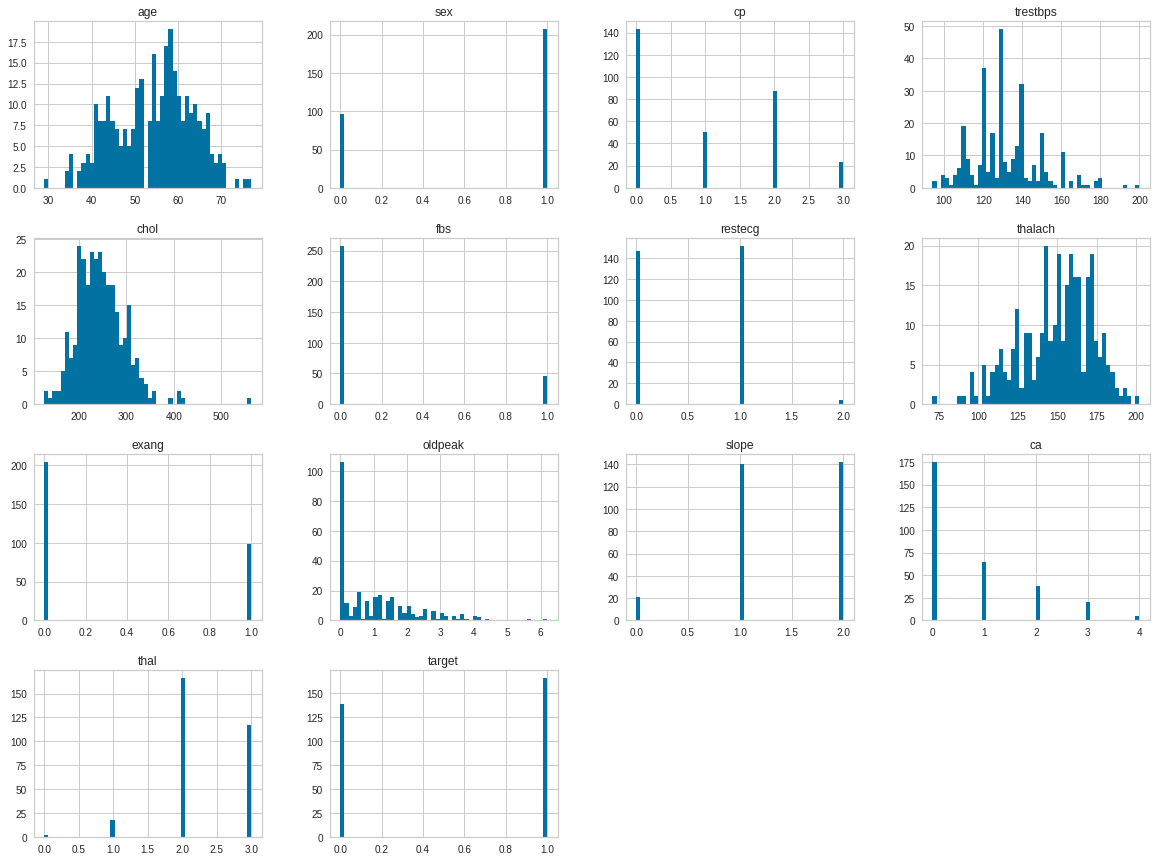

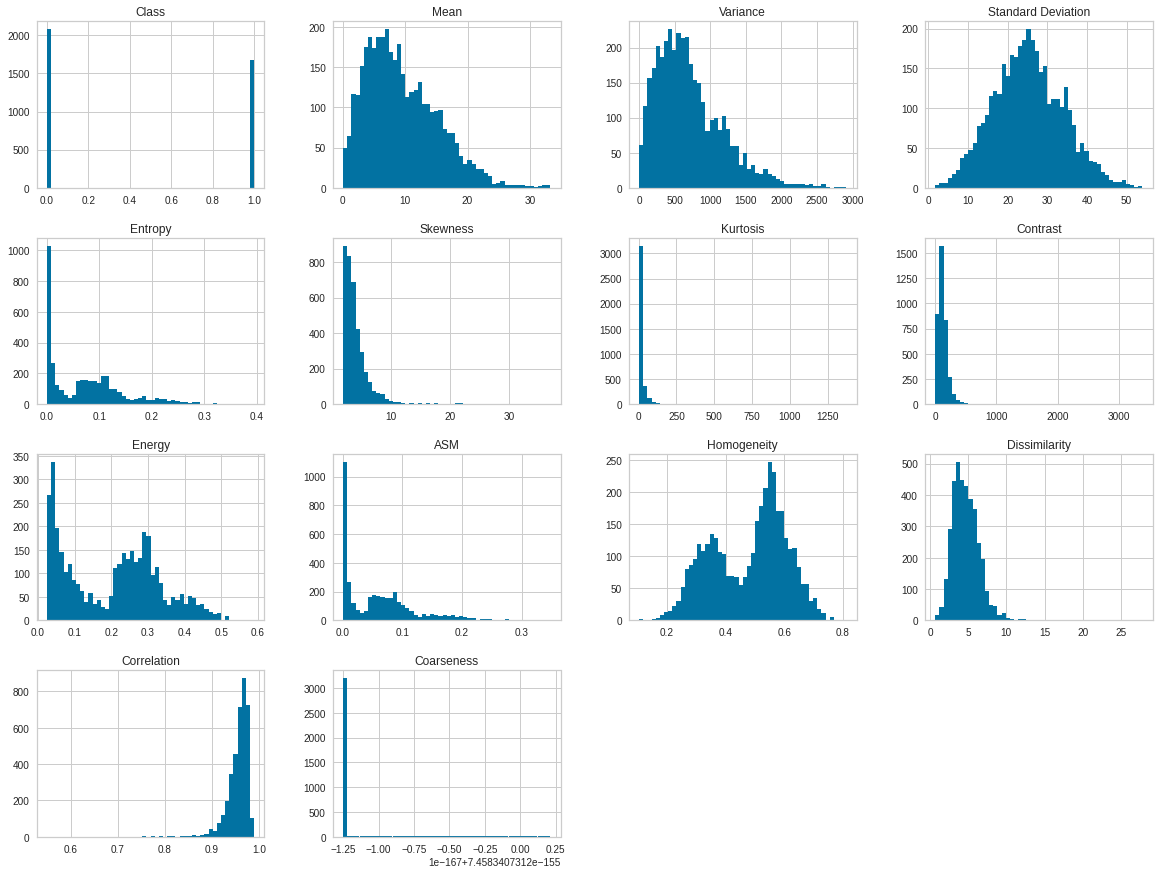

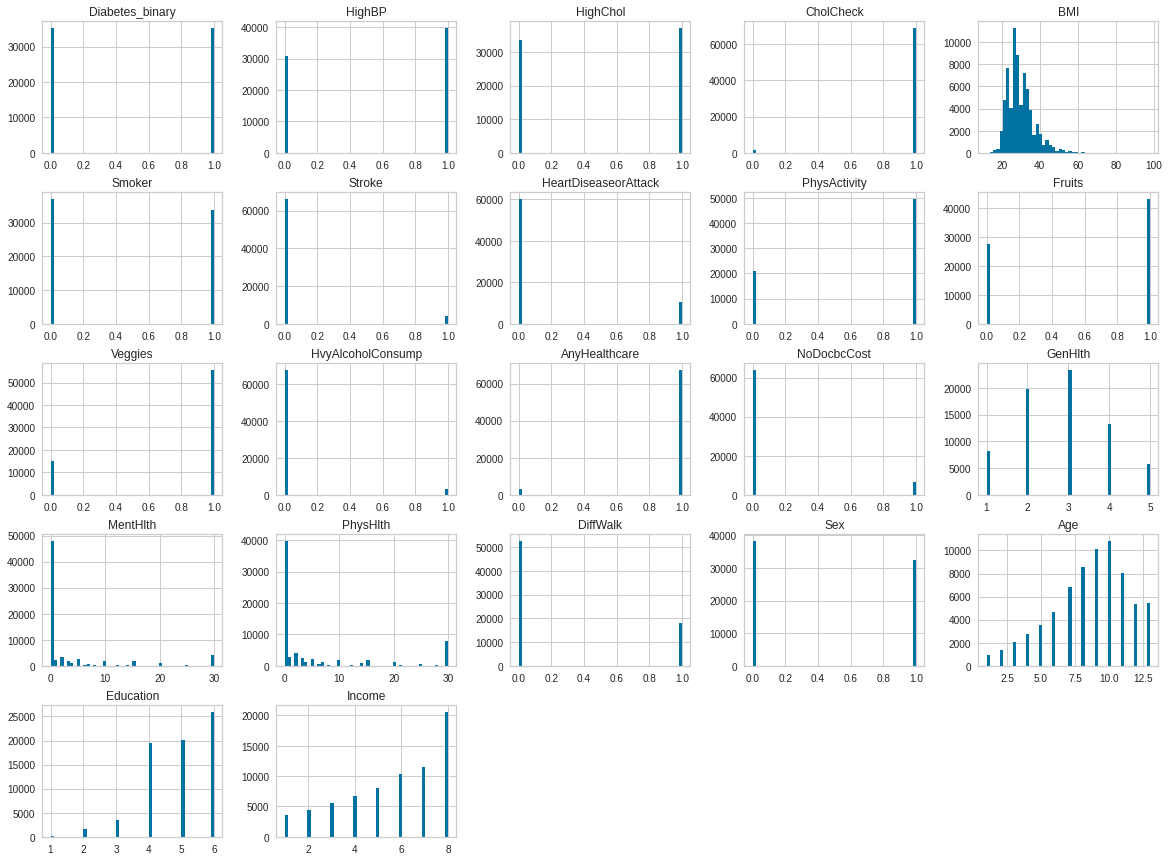

In [7]:
# df1 plot
_ = df1.hist(bins=50, figsize=(20,15))
plt.savefig('df1plot.png', dpi=1200)


# df2 plot
_ = df2.hist(bins=50, figsize=(20,15))
#plt.savefig('df2plot.png', dpi=1200)

# df3 plot
_ = df3.hist(bins=50, figsize=(20,15))
#plt.savefig('df3plot.png', dpi=1200)

Look at the data types of the columns in the dataframes

In [121]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Class               3762 non-null   int64  
 1   Mean                3762 non-null   float64
 2   Variance            3762 non-null   float64
 3   Standard Deviation  3762 non-null   float64
 4   Entropy             3762 non-null   float64
 5   Skewness            3762 non-null   float64
 6   Kurtosis            3762 non-null   float64
 7   Contrast            3762 non-null   float64
 8   Energy              3762 non-null   float64
 9   ASM                 3762 non-null   float64
 10  Homogeneity         3762 non-null   float64
 11  Dissimilarity       3762 non-null   float64
 12  Correlation         3762 non-null   float64
 13  Coarseness          3762 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 411.6 KB
None


No missing values in any of the features.

Now look at the count of the target class to make sure they are balanced.

In [9]:
print(df2['Class'].value_counts())

0    2079
1    1683
Name: Class, dtype: int64


Now let's do some checks of the numerical columns.

In [10]:
print(df2.describe())

             Class         Mean     Variance  Standard Deviation      Entropy  \
count  3762.000000  3762.000000  3762.000000         3762.000000  3762.000000   
mean      0.447368     9.488890   711.101063           25.182271     0.073603   
std       0.497288     5.728022   467.466896            8.773526     0.070269   
min       0.000000     0.078659     3.145628            1.773592     0.000882   
25%       0.000000     4.982395   363.225459           19.058475     0.006856   
50%       0.000000     8.477531   622.580417           24.951560     0.066628   
75%       1.000000    13.212723   966.954319           31.095889     0.113284   
max       1.000000    33.239975  2910.581879           53.949809     0.394539   

          Skewness     Kurtosis     Contrast       Energy          ASM  \
count  3762.000000  3762.000000  3762.000000  3762.000000  3762.000000   
mean      4.102727    24.389071   127.961459     0.204705     0.058632   
std       2.560940    56.434747   109.499601    

Create a histogram of the numerical columns of the datasets

Look at the data types of the columns in the dataframes

In [11]:
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

No missing values in any of the datasets.

Now look at the count of the target class to make sure they are balanced.

In [12]:
print(df3['Diabetes_binary'].value_counts())

0.0    35346
1.0    35346
Name: Diabetes_binary, dtype: int64


The dataset is equally balanced so we can undersample either Class to achieve an imbalance of 90%.

Now let's do some checks of the numerical columns.

In [13]:
print(df3.describe())

       Diabetes_binary        HighBP      HighChol     CholCheck  \
count     70692.000000  70692.000000  70692.000000  70692.000000   
mean          0.500000      0.563458      0.525703      0.975259   
std           0.500004      0.495960      0.499342      0.155336   
min           0.000000      0.000000      0.000000      0.000000   
25%           0.000000      0.000000      0.000000      1.000000   
50%           0.500000      1.000000      1.000000      1.000000   
75%           1.000000      1.000000      1.000000      1.000000   
max           1.000000      1.000000      1.000000      1.000000   

                BMI        Smoker        Stroke  HeartDiseaseorAttack  \
count  70692.000000  70692.000000  70692.000000          70692.000000   
mean      29.856985      0.475273      0.062171              0.147810   
std        7.113954      0.499392      0.241468              0.354914   
min       12.000000      0.000000      0.000000              0.000000   
25%       25.000000   

Create a histogram of the numerical columns of the datasets

# Step 3: Preprocessing 

Use One Hot Encoding for the categorical values

In [14]:
df1_features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal']

df2_features = ['Mean', 'Variance', 'Standard Deviation', 'Entropy',
       'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity',
       'Dissimilarity', 'Correlation', 'Coarseness'] 

df3_features = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income']



In [15]:
# convert categorical values into dummy/indicator variables
df1_dummies = pd.get_dummies(df1, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])
df1 = df1_dummies
df1

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0.2,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1
299,45,110,264,132,1.2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
300,68,144,193,141,3.4,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
301,57,130,131,115,1.2,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1


In [16]:
# convert categorical values into dummy/indicator variables
df3_dummies = pd.get_dummies(df3, columns=['HighBP', 'HighChol', 'CholCheck', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'])
#df3 = df3_dummies
#df3
df3 = df3_dummies

In [122]:
df1

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0.2,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1
299,45,110,264,132,1.2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
300,68,144,193,141,3.4,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
301,57,130,131,115,1.2,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1


In [18]:
df1_newfeatures = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex_0', 'sex_1',
       'cp_0', 'cp_1', 'cp_2', 'cp_3', 'fbs_0', 'fbs_1', 'restecg_0',
       'restecg_1', 'restecg_2', 'exang_0', 'exang_1', 'slope_0', 'slope_1',
       'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1',
       'thal_2', 'thal_3']
df2_newfeatures = df2_features
df3_newfeatures = ['BMI','HighBP_0.0','HighBP_1.0','HighChol_0.0','HighChol_1.0','CholCheck_0.0','CholCheck_1.0','Smoker_0.0',
 'Smoker_1.0','Stroke_0.0','Stroke_1.0','HeartDiseaseorAttack_0.0', 'HeartDiseaseorAttack_1.0','PhysActivity_0.0', 'PhysActivity_1.0',
 'Fruits_0.0','Fruits_1.0','Veggies_0.0','Veggies_1.0', 'HvyAlcoholConsump_0.0', 'HvyAlcoholConsump_1.0', 'AnyHealthcare_0.0',
 'AnyHealthcare_1.0','NoDocbcCost_0.0','NoDocbcCost_1.0','GenHlth_1.0','GenHlth_2.0','GenHlth_3.0','GenHlth_4.0','GenHlth_5.0','MentHlth_0.0','MentHlth_1.0',
 'MentHlth_2.0','MentHlth_3.0','MentHlth_4.0','MentHlth_5.0','MentHlth_6.0','MentHlth_7.0','MentHlth_8.0','MentHlth_9.0','MentHlth_10.0','MentHlth_11.0',
 'MentHlth_12.0','MentHlth_13.0','MentHlth_14.0','MentHlth_15.0', 'MentHlth_16.0','MentHlth_17.0','MentHlth_18.0','MentHlth_19.0','MentHlth_20.0','MentHlth_21.0',
 'MentHlth_22.0','MentHlth_23.0','MentHlth_24.0','MentHlth_25.0', 'MentHlth_26.0', 'MentHlth_27.0','MentHlth_28.0','MentHlth_29.0','MentHlth_30.0',
 'PhysHlth_0.0', 'PhysHlth_1.0','PhysHlth_2.0','PhysHlth_3.0','PhysHlth_4.0', 'PhysHlth_5.0','PhysHlth_6.0', 'PhysHlth_7.0','PhysHlth_8.0','PhysHlth_9.0','PhysHlth_10.0',
 'PhysHlth_11.0','PhysHlth_12.0','PhysHlth_13.0', 'PhysHlth_14.0','PhysHlth_15.0','PhysHlth_16.0','PhysHlth_17.0', 'PhysHlth_18.0','PhysHlth_19.0','PhysHlth_20.0',
 'PhysHlth_21.0','PhysHlth_22.0', 'PhysHlth_23.0','PhysHlth_24.0','PhysHlth_25.0','PhysHlth_26.0','PhysHlth_27.0','PhysHlth_28.0', 'PhysHlth_29.0','PhysHlth_30.0','DiffWalk_0.0',
 'DiffWalk_1.0','Sex_0.0','Sex_1.0', 'Age_1.0', 'Age_2.0','Age_3.0','Age_4.0', 'Age_5.0','Age_6.0','Age_7.0','Age_8.0', 'Age_9.0', 'Age_10.0','Age_11.0',
 'Age_12.0','Age_13.0','Education_1.0','Education_2.0', 'Education_3.0', 'Education_4.0','Education_5.0','Education_6.0','Income_1.0','Income_2.0',
 'Income_3.0','Income_4.0','Income_5.0', 'Income_6.0', 'Income_7.0','Income_8.0']

# Step 4: Creating Imbalance

We create versions/surrogates in addition to the original data by subsamspling one of the classes.

In [19]:
df1['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [26]:
df3['Diabetes_binary']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
70687    1.0
70688    1.0
70689    1.0
70690    1.0
70691    1.0
Name: Diabetes_binary, Length: 70692, dtype: float64

In [27]:
# code below adapted from [https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets]

# dataset 1
# class count
count_class_0, count_class_1 = df1.target.value_counts()
# divide by class
df_class_0 = df1[df1['target'] == 0]
df_class_1 = df1[df1['target'] == 1]
df_class_0_under = df_class_0.sample(89)
df1_low = pd.concat([df_class_0_under, df_class_1], axis=0)
df_class_0_under = df_class_0.sample(55)
df1_med = pd.concat([df_class_0_under, df_class_1], axis=0)
df_class_0_under = df_class_0.sample(18)
df1_high = pd.concat([df_class_0_under, df_class_1], axis=0)
print("Dataset 1")
print(f"Low Imbalance: \n {df1_low['target'].value_counts()}")
print(f"Med Imbalance: \n {df1_med['target'].value_counts()}")
print(f"High Imbalance: \n {df1_high['target'].value_counts()}")
print(" ")
#----------------------------------------------------------------------------------------------------------

# dataset 2
# class count
count_class_0, count_class_1 = df2.Class.value_counts()
# divide by class
df_class_0 = df2[df2['Class'] == 0]
df_class_1 = df2[df2['Class'] == 1]
df_class_0_under = df_class_0.sample(906)
df2_low = pd.concat([df_class_0_under, df_class_1], axis=0)
df_class_0_under = df_class_0.sample(561)
df2_med = pd.concat([df_class_0_under, df_class_1], axis=0)
df_class_0_under = df_class_0.sample(187)
df2_high = pd.concat([df_class_0_under, df_class_1], axis=0)
print("Dataset 2")
print(f"Low Imbalance: \n {df2_low['Class'].value_counts()}")
print(f"Med Imbalance: \n {df2_med['Class'].value_counts()}")
print(f"High Imbalance: \n {df2_high['Class'].value_counts()}")
print("")
#---------------------------------------------------------------------------------------------------------

# dataset 3
# class count
count_class_0, count_class_1 = df3.Diabetes_binary.value_counts()
# divide by class
df_class_0 = df3[df3['Diabetes_binary'] == 0]
df_class_1 = df3[df3['Diabetes_binary'] == 1]
# create low imbalance
df_class_1_under = df_class_1.sample(19032)
df3_low = pd.concat([df_class_1_under, df_class_0], axis=0)
# create medium imbalance
df_class_1_under = df_class_1.sample(11782)
df3_med = pd.concat([df_class_1_under, df_class_0], axis=0)
# create high imbalance
df_class_1_under = df_class_1.sample(3927)
df3_high = pd.concat([df_class_1_under, df_class_0], axis=0)
print("Dataset 3")
print(f"Low Imbalance: \n {df3_low['Diabetes_binary'].value_counts()}")
print(f"Med Imbalance: \n {df3_med['Diabetes_binary'].value_counts()}")
print(f"High Imbalance: \n {df3_high['Diabetes_binary'].value_counts()}")

Dataset 1
Low Imbalance: 
 1    165
0     89
Name: target, dtype: int64
Med Imbalance: 
 1    165
0     55
Name: target, dtype: int64
High Imbalance: 
 1    165
0     18
Name: target, dtype: int64
 
Dataset 2
Low Imbalance: 
 1    1683
0     906
Name: Class, dtype: int64
Med Imbalance: 
 1    1683
0     561
Name: Class, dtype: int64
High Imbalance: 
 1    1683
0     187
Name: Class, dtype: int64

Dataset 3
Low Imbalance: 
 0.0    35346
1.0    19032
Name: Diabetes_binary, dtype: int64
Med Imbalance: 
 0.0    35346
1.0    11782
Name: Diabetes_binary, dtype: int64
High Imbalance: 
 0.0    35346
1.0     3927
Name: Diabetes_binary, dtype: int64


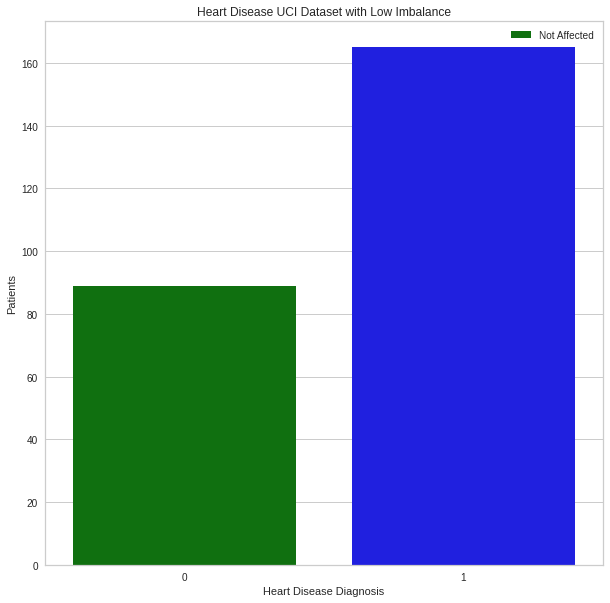

In [138]:
fig = plt.subplots(figsize=(10,10))
sns.countplot(x = df1_low['target'], palette=['Green','Blue'])
plt.xlabel('Heart Disease Diagnosis')
plt.ylabel('Patients')
plt.legend(['Not Affected', 'Affected'])
plt.title('Heart Disease UCI Dataset with Low Imbalance')
#plt.savefig('D1Low.png', dpi=1200)
plt.show()

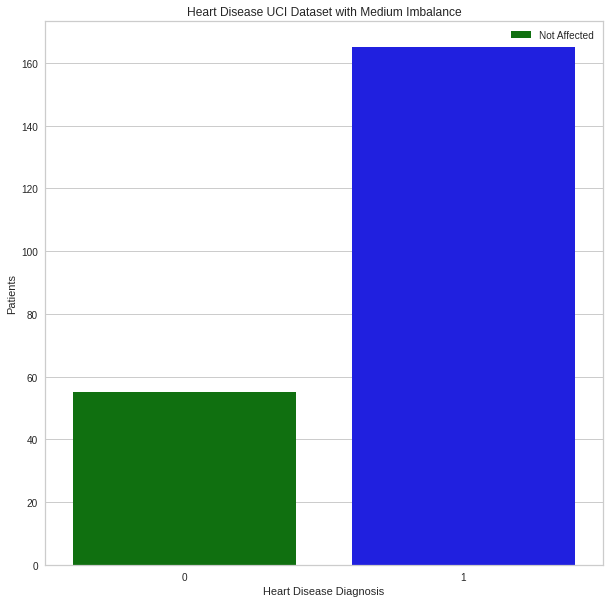

In [139]:
fig = plt.subplots(figsize=(10,10))
sns.countplot(x = df1_med['target'], palette=['Green','Blue'])
plt.xlabel('Heart Disease Diagnosis')
plt.ylabel('Patients')
plt.legend(['Not Affected', 'Affected'])
plt.title('Heart Disease UCI Dataset with Medium Imbalance')
#plt.savefig('D1Med.png', dpi=1200)
plt.show()

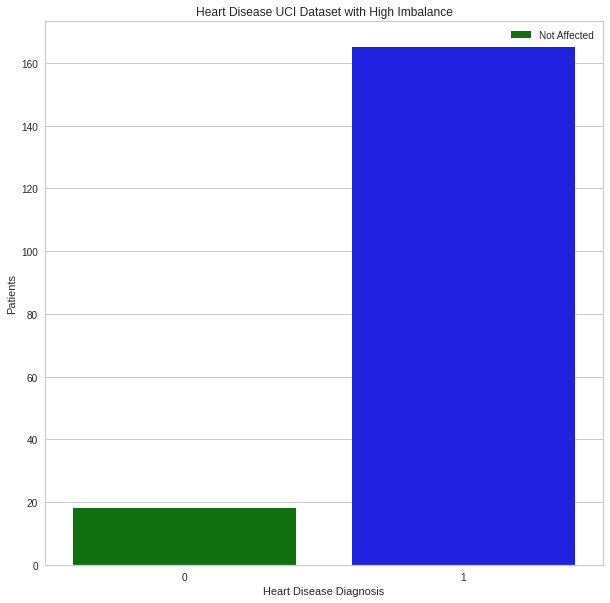

In [140]:
fig = plt.subplots(figsize=(10,10))
sns.countplot(x = df1_high['target'], palette=['Green','Blue'])
plt.xlabel('Heart Disease Diagnosis')
plt.ylabel('Patients')
plt.legend(['Not Affected', 'Affected'])
plt.title('Heart Disease UCI Dataset with High Imbalance')
#plt.savefig('D1High.png', dpi=1200)
plt.show()

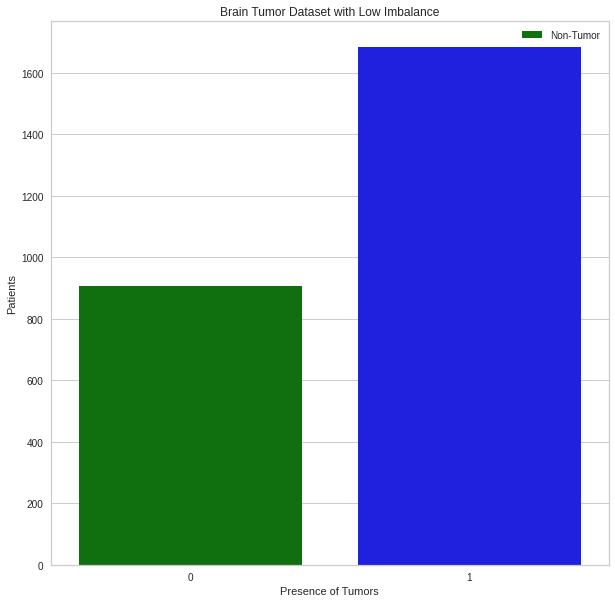

In [141]:
fig = plt.subplots(figsize=(10,10))
sns.countplot(x = df2_low['Class'], palette=['Green','Blue'])
plt.xlabel('Presence of Tumors')
plt.ylabel('Patients')
plt.legend(['Non-Tumor', 'Tumor'])
plt.title('Brain Tumor Dataset with Low Imbalance')
#plt.savefig('D2Low.png', dpi=1200)
plt.show()

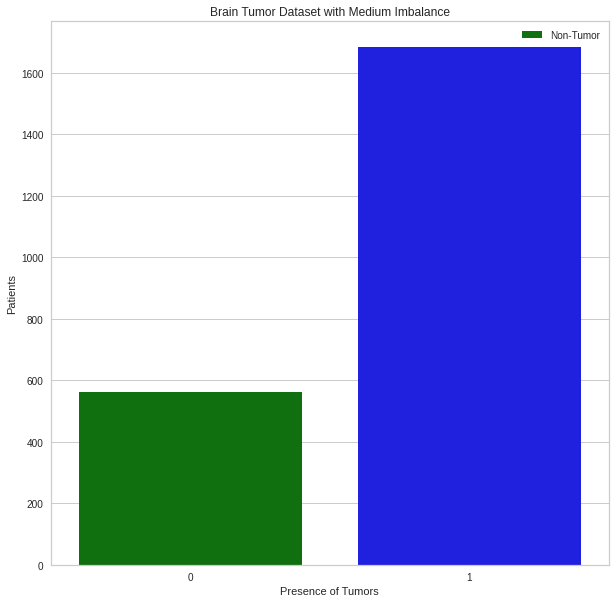

In [142]:
fig = plt.subplots(figsize=(10,10))
sns.countplot(x = df2_med['Class'], palette=['Green','Blue'])
plt.xlabel('Presence of Tumors')
plt.ylabel('Patients')
plt.legend(['Non-Tumor', 'Tumor'])
plt.title('Brain Tumor Dataset with Medium Imbalance')
#plt.savefig('D2Med.png', dpi=1200)
plt.show()

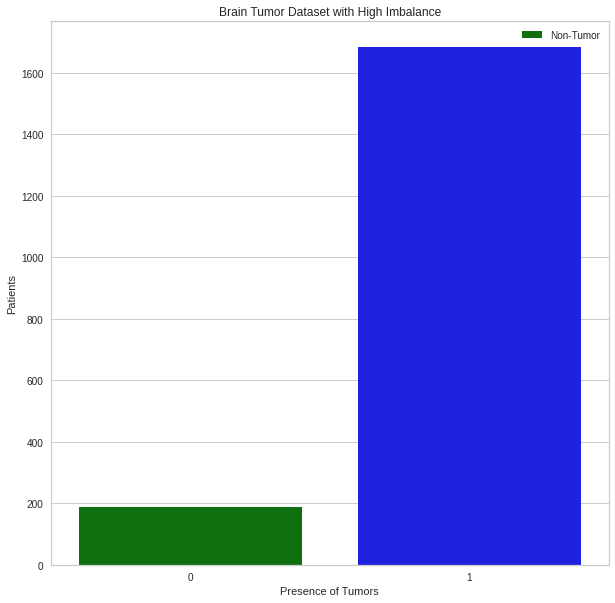

In [143]:
fig = plt.subplots(figsize=(10,10))
sns.countplot(x = df2_high['Class'], palette=['Green','Blue'])
plt.xlabel('Presence of Tumors')
plt.ylabel('Patients')
plt.legend(['Non-Tumor', 'Tumor'])
plt.title('Brain Tumor Dataset with High Imbalance')
#plt.savefig('D2High.png', dpi=1200)
plt.show()

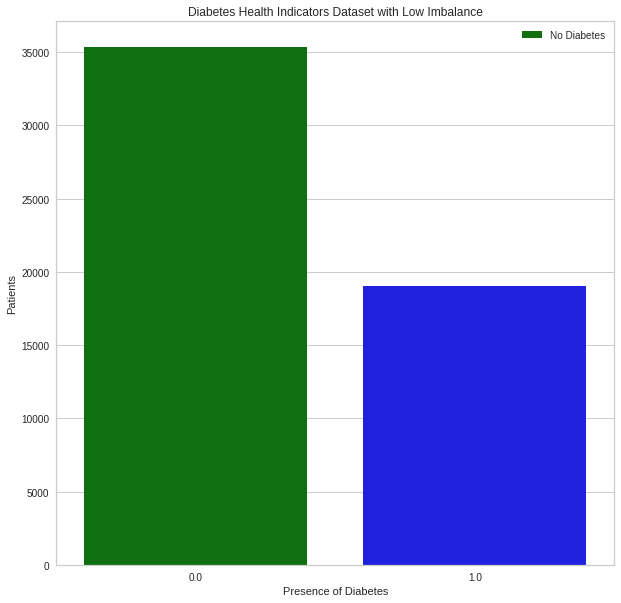

In [144]:
# draw plots to visualize data
fig = plt.subplots(figsize=(10,10))
sns.countplot(x = df3_low['Diabetes_binary'], palette=['Green','Blue'])
plt.xlabel('Presence of Diabetes')
plt.ylabel('Patients')
plt.legend(['No Diabetes', 'Diabetes'])
plt.title('Diabetes Health Indicators Dataset with Low Imbalance')
#plt.savefig('D3Low.png', dpi=1200)
plt.show()

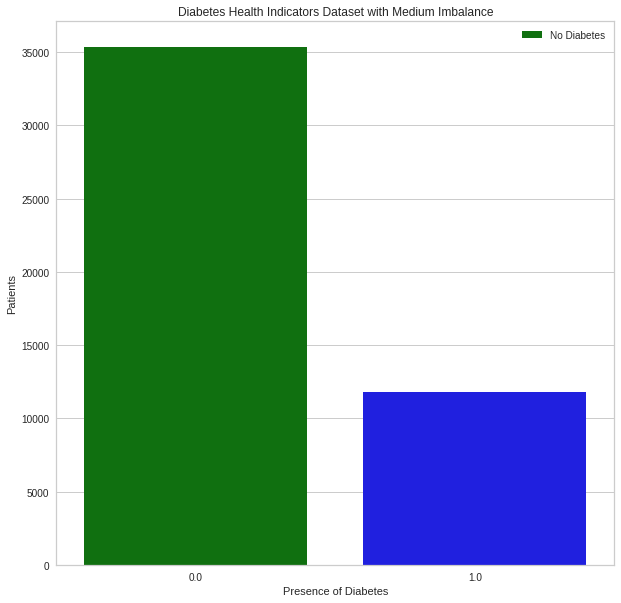

In [145]:
fig = plt.subplots(figsize=(10,10))
sns.countplot(x = df3_med['Diabetes_binary'], palette=['Green','Blue'])
plt.xlabel('Presence of Diabetes')
plt.ylabel('Patients')
plt.legend(['No Diabetes', 'Diabetes'])
plt.title('Diabetes Health Indicators Dataset with Medium Imbalance')
#plt.savefig('D3Med.png', dpi=1200)
plt.show()

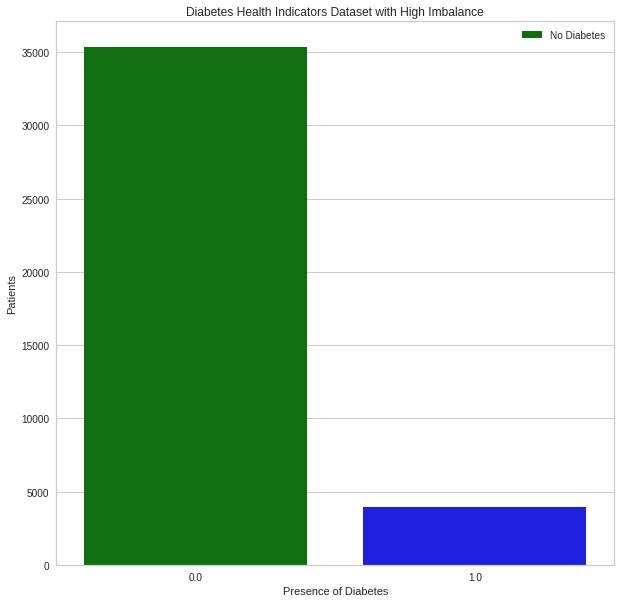

In [146]:
fig = plt.subplots(figsize=(10,10))
sns.countplot(x = df3_high['Diabetes_binary'], palette=['Green','Blue'])
plt.xlabel('Presence of Diabetes')
plt.ylabel('Patients')
plt.legend(['No Diabetes', 'Diabetes'])
plt.title('Diabetes Health Indicators Dataset with High Imbalance')
#plt.savefig('D3High.png', dpi=1200)
plt.show()

# Step 5: Rescale numerical features

Before training, it is necessary to determine whether the features in the dataset are to scale with each other. This can be done by drawing a boxplot

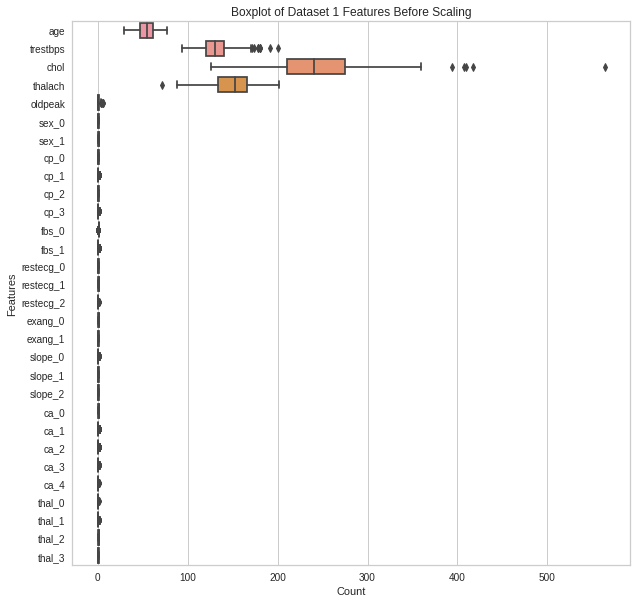

In [151]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data = df1[df1_newfeatures], orient='h')
plt.xlabel('Count')
plt.ylabel('Features')
#plt.legend(['No Diabetes', 'Diabetes'])
plt.title('Boxplot of Dataset 1 Features Before Scaling')
plt.savefig('D1Boxplot.png', dpi=1200)
plt.show()

In [149]:
# dataset 1
X_10 = df1[df1_newfeatures]
X_11 = df1_low[df1_newfeatures]
X_12 = df1_med[df1_newfeatures]
X_13 = df1_high[df1_newfeatures]
y_10 = df1['target']
y_11 = df1_low['target']
y_12 = df1_med['target']
y_13 = df1_high['target']

# column transformer
df1_scaler = ColumnTransformer([
        ('num features', StandardScaler(), ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']),], remainder='passthrough')

#rescale the data and return it to pandas dataframe
X_10 = df1_scaler.fit_transform(X_10)
X_10 = pd.DataFrame(X_10, columns=df1_newfeatures)  
X_11 = df1_scaler.fit_transform(X_11)
X_11 = pd.DataFrame(X_11, columns=df1_newfeatures)  
X_12 = df1_scaler.fit_transform(X_12)
X_12 = pd.DataFrame(X_12, columns=df1_newfeatures)  
X_13 = df1_scaler.fit_transform(X_13)
X_13 = pd.DataFrame(X_13, columns=df1_newfeatures)   
#---------------------------------------------------------------------------------------------------------#

# dataset 2
X_20 = df2[df2_newfeatures]
X_21 = df2_low[df2_newfeatures]
X_22 = df2_med[df2_newfeatures]
X_23 = df2_high[df2_newfeatures]
y_20 = df2['Class']
y_21 = df2_low['Class']
y_22 = df2_med['Class']
y_23 = df2_high['Class']

# column transformer
df2_scaler = ColumnTransformer([
        ('features', StandardScaler(), df2_features)
    ], remainder='passthrough')

#rescale the data and return it to pandas dataframe
X_20 = df2_scaler.fit_transform(X_20)
X_20 = pd.DataFrame(X_20, columns=df2_newfeatures)  
X_21 = df2_scaler.fit_transform(X_21)
X_21 = pd.DataFrame(X_21, columns=df2_newfeatures)  
X_22 = df2_scaler.fit_transform(X_22)
X_22 = pd.DataFrame(X_22, columns=df2_newfeatures)  
X_23 = df2_scaler.fit_transform(X_23)
X_23 = pd.DataFrame(X_23, columns=df2_newfeatures)  
#---------------------------------------------------------------------------------------------------------#

# dataset 3
X_30 = df3[df3_newfeatures]
X_31 = df3_low[df3_newfeatures]
X_32 = df3_med[df3_newfeatures]
X_33 = df3_high[df3_newfeatures]
y_30 = df3['Diabetes_binary']
y_31 = df3_low['Diabetes_binary']
y_32 = df3_med['Diabetes_binary']
y_33 = df3_high['Diabetes_binary']

# column transformer
df3_scaler = ColumnTransformer([
        ('num features', StandardScaler(), ['BMI'])
    ], remainder='passthrough')

#rescale the data and return it to pandas dataframe
X_30 = df3_scaler.fit_transform(X_30)
X_30 = pd.DataFrame(X_30, columns=df3_newfeatures)  
X_31 = df3_scaler.fit_transform(X_31)
X_31 = pd.DataFrame(X_31, columns=df3_newfeatures)  
X_32 = df3_scaler.fit_transform(X_32)
X_32 = pd.DataFrame(X_32, columns=df3_newfeatures)  
X_33 = df3_scaler.fit_transform(X_33)
X_33 = pd.DataFrame(X_33, columns=df3_newfeatures)  

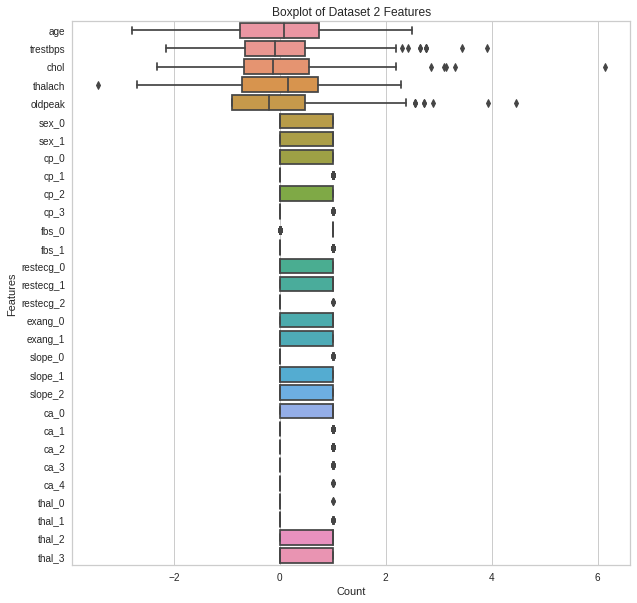

In [153]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data = X_10, orient='h')
plt.xlabel('Count')
plt.ylabel('Features')
plt.title('Boxplot of Dataset 2 Features')
plt.savefig('D1Boxplotscaled.png', dpi=1200)
plt.show()

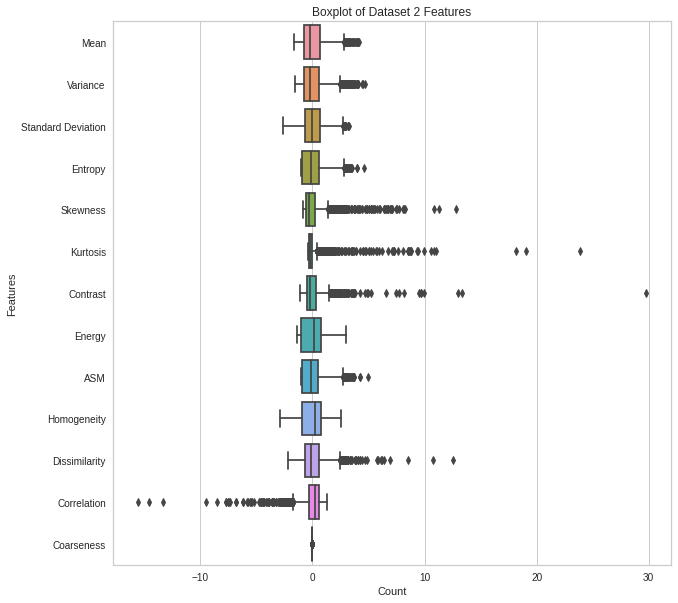

In [129]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data = X_20, orient='h')
plt.xlabel('Count')
plt.ylabel('Features')
plt.title('Boxplot of Dataset 2 Features')
plt.savefig('D2Boxplot.png', dpi=1200)
plt.show()

Rescale some features to make it more in line with the remaining features.

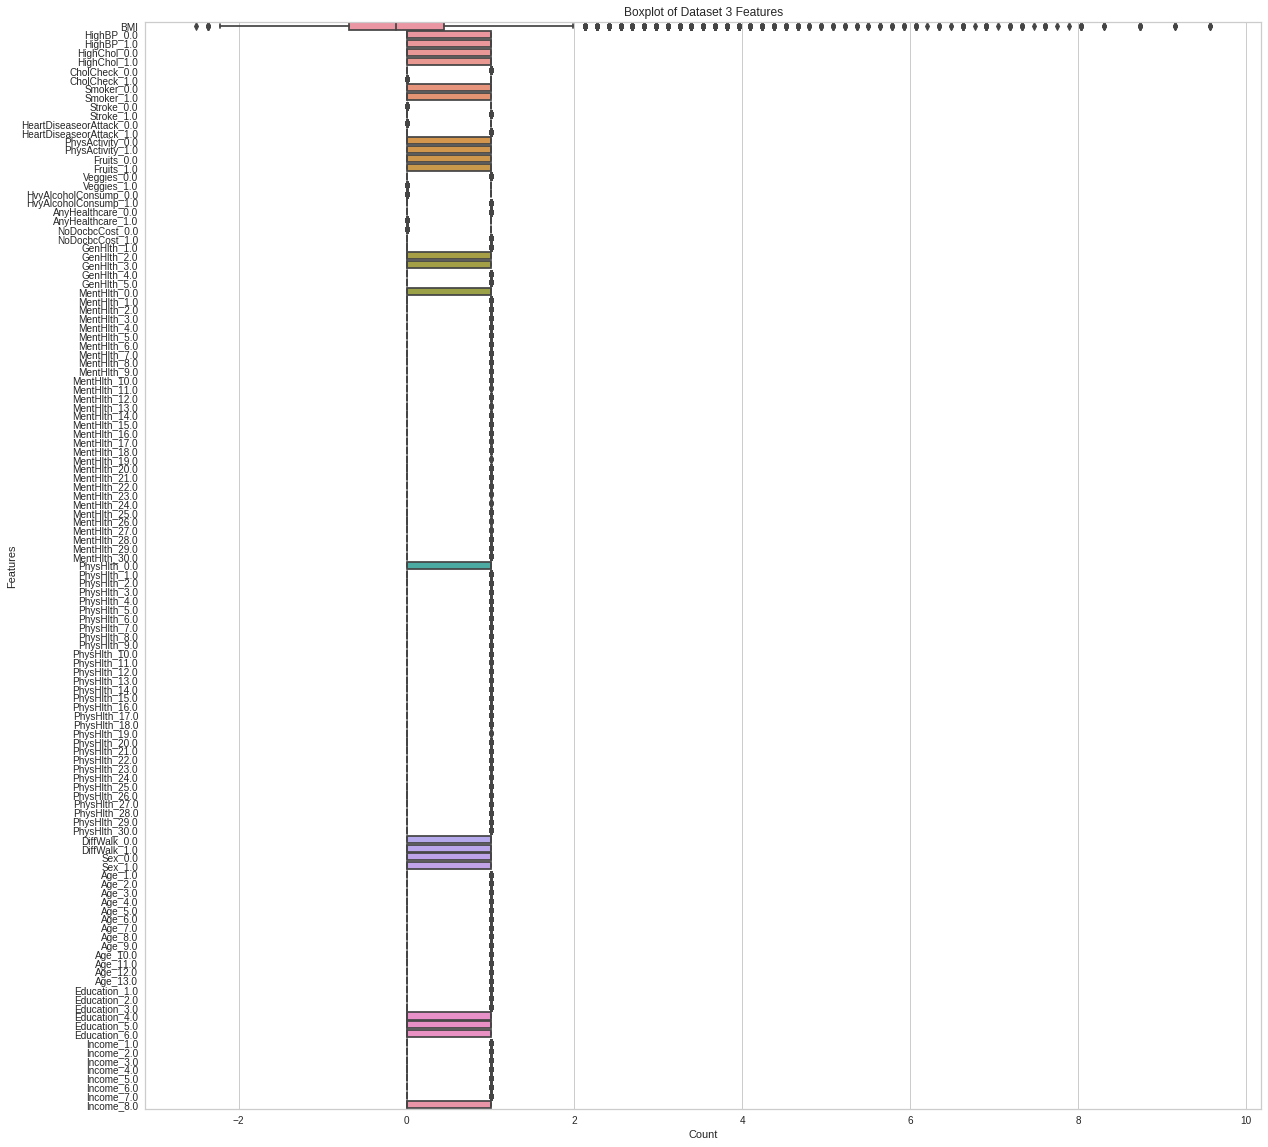

In [132]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(data = X_30, orient='h')
plt.xlabel('Count')
plt.ylabel('Features')
plt.title('Boxplot of Dataset 3 Features')
plt.show()

Create a function to train a Random Forest Classifier on the dataset for baseline scores

In [80]:
def RandomForest(X,y):
    # split the data
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y)
    # create random forest classifier and fit with the training set
    rfc = RandomForestClassifier()
    rfc.fit(X_tr, y_tr)
    rfc.predict(X_te)
    rfc_scores = cross_val_score(rfc, X, y, cv=10, scoring='f1')
    print("F1 Score:   %.2f +/- %.2f" % (rfc_scores.mean(), rfc_scores.std()))

In [133]:
print("Dataset 1: Unbalanced, Low, Medium, High")
RandomForest(X_10, y_10)
RandomForest(X_11, y_11)
RandomForest(X_12, y_12)
RandomForest(X_13, y_13)
print(" ")
print("Dataset 2 Unbalanced, Low, Medium, High")
RandomForest(X_20, y_20)
RandomForest(X_21, y_21)
RandomForest(X_22, y_22)
RandomForest(X_23, y_23)
print(" ")
print("Dataset 3 Unbalanced, Low, Medium, High")
RandomForest(X_30, y_30)
RandomForest(X_31, y_31)
RandomForest(X_32, y_32)
RandomForest(X_33, y_33)

Dataset 1: Unbalanced, Low, Medium, High
F1 Score:   0.85 +/- 0.05
F1 Score:   0.86 +/- 0.05
F1 Score:   0.93 +/- 0.04
F1 Score:   0.96 +/- 0.02
 
Dataset 2 Unbalanced, Low, Medium, High
F1 Score:   0.99 +/- 0.01
F1 Score:   0.99 +/- 0.01
F1 Score:   0.99 +/- 0.00
F1 Score:   0.99 +/- 0.01
 
Dataset 3 Unbalanced, Low, Medium, High
F1 Score:   0.74 +/- 0.01
F1 Score:   0.62 +/- 0.01
F1 Score:   0.48 +/- 0.01
F1 Score:   0.10 +/- 0.01


##Step 5: Create 10 stratified folds and find the clusters

StratifiedKFold divides all the samples in  groups of samples, called folds (if , this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using  folds, and the fold left out is used for test.


In [155]:
# create function for dataset 1
def Stratified1(X, y):
    km_model = KMeans()
    skf = StratifiedKFold(n_splits = 10, shuffle=True)
    # create a for loop to identify number of clusters
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    elbow_viz = KElbowVisualizer(km_model, k=(1,14), metric='distortion', timings=False)
    elbow_viz.fit(X_train, y_train)        # Fit the data to the visualizer
    elbow_viz.show()        # Finalize and render the figure  
    sil_viz = KElbowVisualizer(km_model, k=(2,14), metric='silhouette', timings=False)
    sil_viz.fit(X_train, y_train)        # Fit the data to the visualizer
    sil_viz.show()        # Finalize and render the figure

    # use kmeans  using identified clusters to find centroid
    # the average of the elbow and silhouette k values will be used
    n = int(np.ceil((elbow_viz.elbow_value_ + sil_viz.elbow_value_)/2))
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X_train, y_train)
    clusters = kmeans.labels_
    labels = kmeans.predict(X_train)
    centroids = kmeans.cluster_centers_
    centroids_mean = []
    #X_train['data_index'] = X_train.index.values
    #print(labels)
    #print(centroids)

    # this loop finds the centroids for each cluster and the mean values
    # for those centroids to find the lowest output criteria
    for i in range(len(centroids)):   
        #print(f"Cluster {i}: {centroids[i]}")
        print(f"Centroid of cluster {i} = {centroids[i].mean()}")
        print(" ")
        centroids_mean.append(centroids[i].mean())
    # this variable is the smallest centroid mean value
    fin_cluster = min(centroids_mean)

    # create new column to add cluster labels to dataframe
    X_train['cluster label'] = pd.Series(clusters, index=X_train.index)
    #X_test['cluster label'] = pd.Series(clusters, index=X_test.index)
    # concatenate X_train and y_train to compare target values
    X_tr_new = pd.concat([X_train, y_train], axis=1)
    #X_te_new = pd.concat([X_test, y_test], axis=1)
    # create another for loop
    for i in range(len(centroids)):
      # slice the dataframe based on clusters
      cluster_sample1 = X_tr_new[X_tr_new['cluster label']==i].value_counts(X_tr_new['target'])
      #cluster_sample2 = X_te_new[X_te_new['cluster label']==i].value_counts(X_te_new['target'])
      print(f"Cluster {i} Samples: {cluster_sample1} ")
      print("")
    iscore_mean = []
    iscore_std = []
    for i in range(len(centroids)):
      # train random forest
      if (X_tr_new.where(X_tr_new['cluster label']==0).dropna().target.nunique() ) > 1:
        X_c0 = X_tr_new.where(X_tr_new['cluster label']==i)
        #X_c1 = X_te_new.where(X_te_new['cluster label']==i)
        X_c0 = X_c0.dropna()
        #X_c1 = X_c1.dropna()
        y0 = X_c0['target']
        #y1 = X_c1['target']
        X_c0 = X_c0.drop('target', axis=1)
        #X_c1 = X_c1.drop('target', axis=1)
        rfc = RandomForestClassifier()
        rfc.fit(X_c0, y0)
        scores = cross_val_score(rfc, X_c0, y0, cv=3, scoring='f1')
        iscore_mean.append(scores.mean())
        iscore_std.append(scores.std())
        print("Cluster " + str(i) + " F1 Score:   %.2f +/- %.2f" % (scores.mean(), scores.std()))
    print("Average F1 Score:  " + " %.2f +/- %.2f" % (np.mean(iscore_mean), np.mean(iscore_std))      )



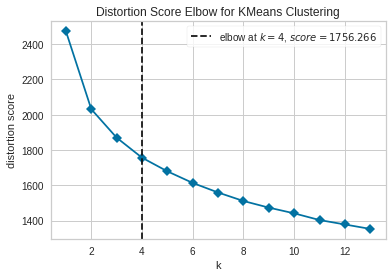

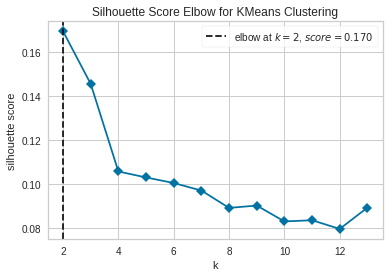

Centroid of cluster 0 = 0.34210827156738655
 
Centroid of cluster 1 = 0.279118632697997
 
Centroid of cluster 2 = 0.2235794609962463
 
Cluster 0 Samples: target
1    29
0    18
dtype: int64 

Cluster 1 Samples: target
0    84
1    18
dtype: int64 

Cluster 2 Samples: target
1    102
0     22
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.79 +/- 0.10
Cluster 1 F1 Score:   0.61 +/- 0.08
Cluster 2 F1 Score:   0.90 +/- 0.01
Average F1 Score:   0.77 +/- 0.06


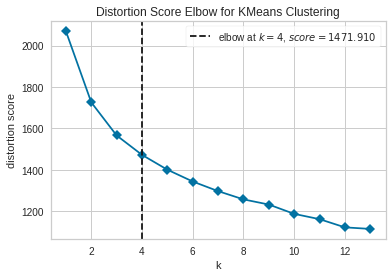

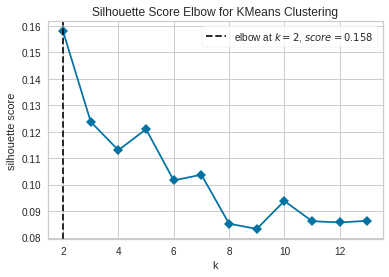

Centroid of cluster 0 = 0.2717889547688453
 
Centroid of cluster 1 = 0.2300935305355973
 
Centroid of cluster 2 = 0.3446596639715862
 
Cluster 0 Samples: target
1.0    57
0.0     9
dtype: int64 

Cluster 1 Samples: target
1.0    53
0.0    28
dtype: int64 

Cluster 2 Samples: target
1.0    26
0.0     8
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.94 +/- 0.01
Cluster 1 F1 Score:   0.72 +/- 0.03
Cluster 2 F1 Score:   0.73 +/- 0.09
Average F1 Score:   0.80 +/- 0.04


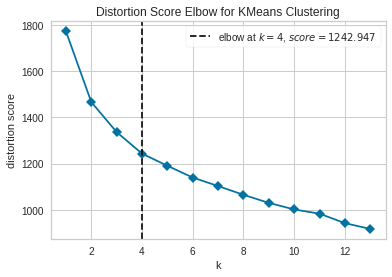

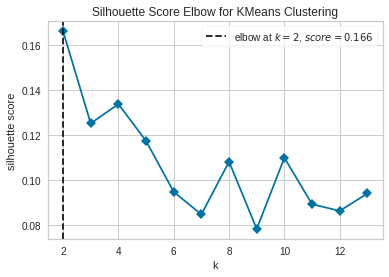

Centroid of cluster 0 = 0.29308170962190705
 
Centroid of cluster 1 = 0.2337327538782087
 
Centroid of cluster 2 = 0.3075041000141727
 
Cluster 0 Samples: target
1.0    34
0.0     3
dtype: int64 

Cluster 1 Samples: target
1.0    57
0.0     9
dtype: int64 

Cluster 2 Samples: target
1.0    41
0.0     4
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.96 +/- 0.00
Cluster 1 F1 Score:   0.92 +/- 0.01
Cluster 2 F1 Score:   0.95 +/- 0.02
Average F1 Score:   0.94 +/- 0.01


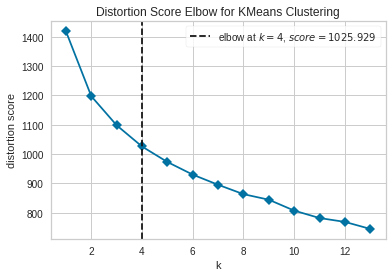

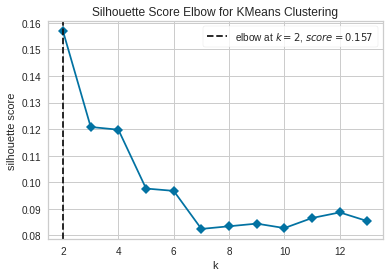

Centroid of cluster 0 = 0.25337239799044126
 
Centroid of cluster 1 = 0.32241499489323533
 
Centroid of cluster 2 = 0.22790671289936892
 
Cluster 0 Samples: target
1.0    35
dtype: int64 

Cluster 1 Samples: target
1.0    48
0.0     1
dtype: int64 

Cluster 2 Samples: target
1.0    50
dtype: int64 

Average F1 Score:   nan +/- nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [115]:
Stratified1(X_10, y_10)
Stratified1(X_11, y_11)
Stratified1(X_12, y_12)
Stratified1(X_13, y_13)



In [156]:
# function for dataset 2
def Stratified2(X, y):
    km_model = KMeans()
    skf = StratifiedKFold(n_splits = 10, shuffle=True)
    # create a for loop to identify number of clusters
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    elbow_viz = KElbowVisualizer(km_model, k=(1,14), metric='distortion', timings=False)
    elbow_viz.fit(X_train, y_train)        # Fit the data to the visualizer
    elbow_viz.show()        # Finalize and render the figure  
    sil_viz = KElbowVisualizer(km_model, k=(2,14), metric='silhouette', timings=False)
    sil_viz.fit(X_train, y_train)        # Fit the data to the visualizer
    sil_viz.show()        # Finalize and render the figure

    # use kmeans  using identified clusters to find centroid
    # the average of the elbow and silhouette k values will be used
    n = int(np.ceil((elbow_viz.elbow_value_ + sil_viz.elbow_value_)/2))
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X_train, y_train)
    clusters = kmeans.labels_
    labels = kmeans.predict(X_train)
    centroids = kmeans.cluster_centers_
    centroids_mean = []
    #X_train['data_index'] = X_train.index.values
    #print(labels)
    #print(centroids)

    # this loop finds the centroids for each cluster and the mean values
    # for those centroids to find the lowest output criteria
    for i in range(len(centroids)):   
        #print(f"Cluster {i}: {centroids[i]}")
        print(f"Centroid of cluster {i} = {centroids[i].mean()}")
        print(" ")
        centroids_mean.append(centroids[i].mean())
    # this variable is the smallest centroid mean value
    fin_cluster = min(centroids_mean)

    # create new column to add cluster labels to dataframe
    X_train['cluster label'] = pd.Series(clusters, index=X_train.index)
    #X_test['cluster label'] = pd.Series(clusters, index=X_test.index)
    # concatenate X_train and y_train to compare target values
    X_tr_new = pd.concat([X_train, y_train], axis=1)
    #X_te_new = pd.concat([X_test, y_test], axis=1)
    # create another for loop
    for i in range(len(centroids)):
      # slice the dataframe based on clusters
      cluster_sample1 = X_tr_new[X_tr_new['cluster label']==i].value_counts(X_tr_new['Class'])
      #cluster_sample2 = X_te_new[X_te_new['cluster label']==i].value_counts(X_te_new['Class'])
      print(f"Cluster {i} Samples: {cluster_sample1} ")
      print("")
    iscore_mean = []
    iscore_std = []
    for i in range(len(centroids)):
      # train random forest
      if (X_tr_new.where(X_tr_new['cluster label']==0).dropna().Class.nunique() ) > 1:
        X_c0 = X_tr_new.where(X_tr_new['cluster label']==i)
        #X_c1 = X_te_new.where(X_te_new['cluster label']==i)
        X_c0 = X_c0.dropna()
        #X_c1 = X_c1.dropna()
        y0 = X_c0['Class']
        #y1 = X_c1['Class']
        X_c0 = X_c0.drop('Class', axis=1)
        #X_c1 = X_c1.drop('Class', axis=1)
        rfc = RandomForestClassifier()
        rfc.fit(X_c0, y0)
        scores = cross_val_score(rfc, X_c0, y0, cv=3, scoring='f1')
        iscore_mean.append(scores.mean())
        iscore_std.append(scores.std())
        print("Cluster " + str(i) + " F1 Score:   %.2f +/- %.2f" % (scores.mean(), scores.std()))
    print("Average F1 Score:  " + " %.2f +/- %.2f" % (np.mean(iscore_mean), np.mean(iscore_std))      )


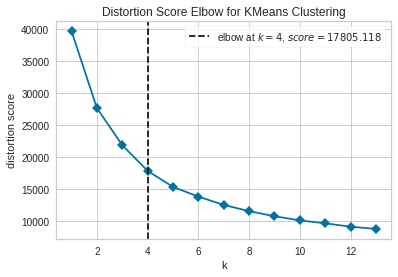

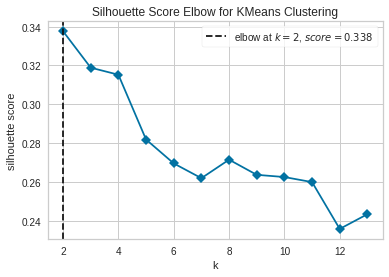

Centroid of cluster 0 = 0.06333746482843297
 
Centroid of cluster 1 = -0.24500773742460466
 
Centroid of cluster 2 = 0.022649256853159935
 
Cluster 0 Samples: Class
0    1553
1      52
dtype: int64 

Cluster 1 Samples: Class
1    549
0      4
dtype: int64 

Cluster 2 Samples: Class
1    913
0    315
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.71 +/- 0.02
Cluster 1 F1 Score:   1.00 +/- 0.00
Cluster 2 F1 Score:   0.99 +/- 0.00
Average F1 Score:   0.90 +/- 0.01


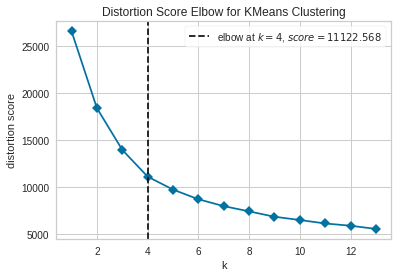

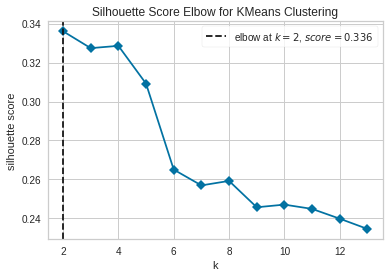

Centroid of cluster 0 = 0.13488412396648697
 
Centroid of cluster 1 = 0.023582981404194937
 
Centroid of cluster 2 = -0.23637840657145176
 
Cluster 0 Samples: Class
0.0    215
1.0    210
dtype: int64 

Cluster 1 Samples: Class
1.0    317
0.0    253
dtype: int64 

Cluster 2 Samples: Class
1.0    208
0.0    130
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.52 +/- 0.02
Cluster 1 F1 Score:   0.58 +/- 0.02
Cluster 2 F1 Score:   0.65 +/- 0.03
Average F1 Score:   0.58 +/- 0.03


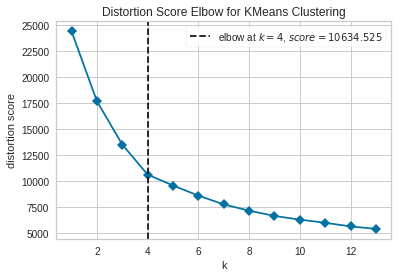

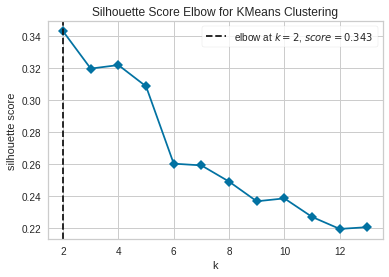

Centroid of cluster 0 = 0.2164521488215734
 
Centroid of cluster 1 = 0.019586647746206293
 
Centroid of cluster 2 = -0.22749810755296643
 
Cluster 0 Samples: Class
1.0    137
0.0     87
dtype: int64 

Cluster 1 Samples: Class
1.0    283
0.0    156
dtype: int64 

Cluster 2 Samples: Class
1.0    172
0.0     96
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.63 +/- 0.08
Cluster 1 F1 Score:   0.75 +/- 0.02
Cluster 2 F1 Score:   0.72 +/- 0.02
Average F1 Score:   0.70 +/- 0.04


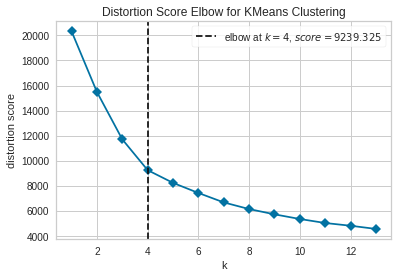

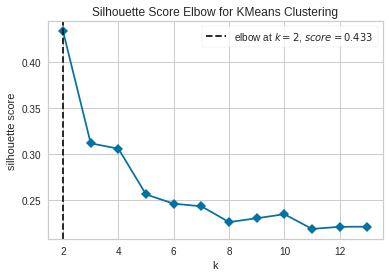

Centroid of cluster 0 = -0.2092297714348736
 
Centroid of cluster 1 = 0.030783233637395713
 
Centroid of cluster 2 = 0.47113788349630564
 
Cluster 0 Samples: Class
1.0    162
0.0     34
dtype: int64 

Cluster 1 Samples: Class
1.0    264
0.0     50
dtype: int64 

Cluster 2 Samples: Class
1.0    55
0.0    12
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.90 +/- 0.01
Cluster 1 F1 Score:   0.89 +/- 0.02
Cluster 2 F1 Score:   0.85 +/- 0.03
Average F1 Score:   0.88 +/- 0.02


In [110]:
Stratified2(X_20, y_20)
Stratified2(X_21, y_21)
Stratified2(X_22, y_22)
Stratified2(X_23, y_23)

In [158]:
def Stratified3(X, y): 
    km_model = KMeans()
    skf = StratifiedKFold(n_splits = 10, shuffle=True)
    # create a for loop to identify number of clusters
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    elbow_viz = KElbowVisualizer(km_model, k=(1,14), metric='distortion', timings=False)
    elbow_viz.fit(X_train, y_train)        # Fit the data to the visualizer
    elbow_viz.show()        # Finalize and render the figure  
    sil_viz = KElbowVisualizer(km_model, k=(2,14), metric='silhouette', timings=False)
    sil_viz.fit(X_train, y_train)        # Fit the data to the visualizer
    sil_viz.show()        # Finalize and render the figure

    # use kmeans  using identified clusters to find centroid
    # the average of the elbow and silhouette k values will be used
    n = int(np.ceil((elbow_viz.elbow_value_ + sil_viz.elbow_value_)/2))
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X_train, y_train)
    clusters = kmeans.labels_
    labels = kmeans.predict(X_train)
    centroids = kmeans.cluster_centers_
    centroids_mean = []
    #X_train['data_index'] = X_train.index.values
    #print(labels)
    #print(centroids)

    # this loop finds the centroids for each cluster and the mean values
    # for those centroids to find the lowest output criteria
    for i in range(len(centroids)):   
        #print(f"Cluster {i}: {centroids[i]}")
        print(f"Centroid of cluster {i} = {centroids[i].mean()}")
        print(" ")
        centroids_mean.append(centroids[i].mean())
    # this variable is the smallest centroid mean value
    fin_cluster = min(centroids_mean)

    # create new column to add cluster labels to dataframe
    X_train['cluster label'] = pd.Series(clusters, index=X_train.index)
    #X_test['cluster label'] = pd.Series(clusters, index=X_test.index)
    # concatenate X_train and y_train to compare target values
    X_tr_new = pd.concat([X_train, y_train], axis=1)
    #X_te_new = pd.concat([X_test, y_test], axis=1)
    # create another for loop
    for i in range(len(centroids)):
      # slice the dataframe based on clusters
      cluster_sample1 = X_tr_new[X_tr_new['cluster label']==i].value_counts(X_tr_new['Diabetes_binary'])
      #cluster_sample2 = X_te_new[X_te_new['cluster label']==i].value_counts(X_te_new['Diabetes_binary'])
      print(f"Cluster {i} Samples: {cluster_sample1} ")
      print("")
    iscore_mean = []
    iscore_std = []
    for i in range(len(centroids)):
      # train random forest
      if (X_tr_new.where(X_tr_new['cluster label']==0).dropna().Diabetes_binary.nunique() ) > 1:
        X_c0 = X_tr_new.where(X_tr_new['cluster label']==i)
        #X_c1 = X_te_new.where(X_te_new['cluster label']==i)
        X_c0 = X_c0.dropna()
        #X_c1 = X_c1.dropna()
        y0 = X_c0['Diabetes_binary']
        #y1 = X_c1['Diabetes_binary']
        X_c0 = X_c0.drop('Diabetes_binary', axis=1)
        #X_c1 = X_c1.drop('Diabetes_binary', axis=1)
        rfc = RandomForestClassifier()
        #rfc.fit(X_c0, y0)
        scores = cross_val_score(rfc, X_c0, y0, cv=3, scoring='f1')
        iscore_mean.append(scores.mean())
        iscore_std.append(scores.std())
        print("Cluster " + str(i) + " F1 Score:   %.2f +/- %.2f" % (scores.mean(), scores.std()))
    print("Average F1 Score:  " + " %.2f +/- %.2f" % (np.mean(iscore_mean), np.mean(iscore_std))      )


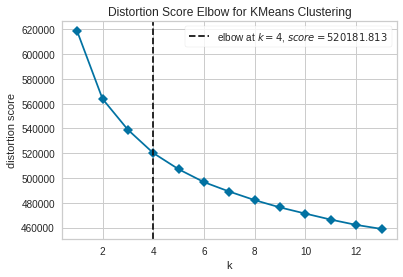

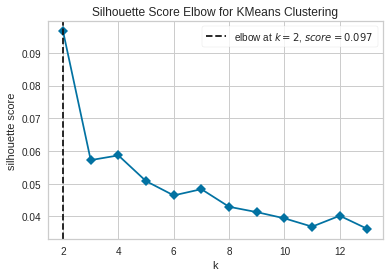

Centroid of cluster 0 = 0.17081235584564577
 
Centroid of cluster 1 = 0.15891839367619404
 
Centroid of cluster 2 = 0.16095037733019255
 
Cluster 0 Samples: Diabetes_binary
1.0    12195
0.0     3513
dtype: int64 

Cluster 1 Samples: Diabetes_binary
0.0    18770
1.0     5858
dtype: int64 

Cluster 2 Samples: Diabetes_binary
1.0    13758
0.0     9529
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.87 +/- 0.00
Cluster 1 F1 Score:   0.40 +/- 0.00
Cluster 2 F1 Score:   0.73 +/- 0.00
Average F1 Score:   0.67 +/- 0.00


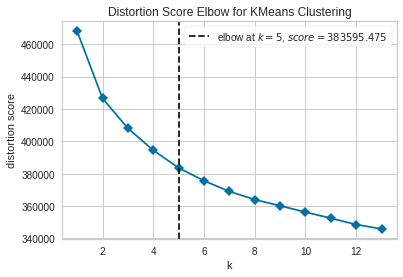

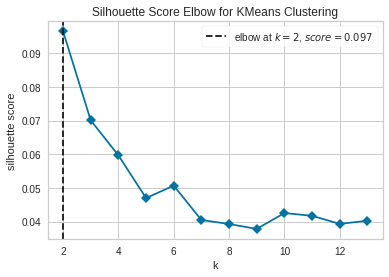

Centroid of cluster 0 = 0.15898168654394323
 
Centroid of cluster 1 = 0.1622811474461765
 
Centroid of cluster 2 = 0.16147694123511205
 
Centroid of cluster 3 = 0.17814879297655697
 
Cluster 0 Samples: Diabetes_binary
0.0    9667
1.0    4572
dtype: int64 

Cluster 1 Samples: Diabetes_binary
0.0    6086
1.0     921
dtype: int64 

Cluster 2 Samples: Diabetes_binary
0.0    8784
1.0    2212
dtype: int64 

Cluster 3 Samples: Diabetes_binary
0.0    4093
1.0     643
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.18 +/- 0.02
Cluster 1 F1 Score:   0.01 +/- 0.00
Cluster 2 F1 Score:   0.08 +/- 0.04
Cluster 3 F1 Score:   0.06 +/- 0.05
Average F1 Score:   0.08 +/- 0.03


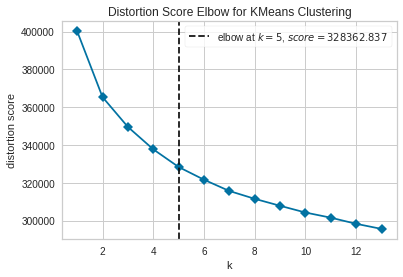

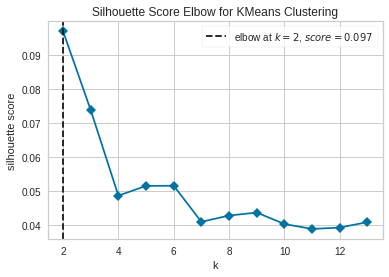

Centroid of cluster 0 = 0.15866282912647606
 
Centroid of cluster 1 = 0.16089629611917436
 
Centroid of cluster 2 = 0.16199944887268572
 
Centroid of cluster 3 = 0.17774895582449
 
Cluster 0 Samples: Diabetes_binary
0.0    8547
1.0    1256
dtype: int64 

Cluster 1 Samples: Diabetes_binary
0.0    8098
1.0    1040
dtype: int64 

Cluster 2 Samples: Diabetes_binary
0.0    7985
1.0     589
dtype: int64 

Cluster 3 Samples: Diabetes_binary
0.0    3989
1.0     287
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.03 +/- 0.01
Cluster 1 F1 Score:   0.04 +/- 0.01
Cluster 2 F1 Score:   0.00 +/- 0.00
Cluster 3 F1 Score:   0.01 +/- 0.02
Average F1 Score:   0.02 +/- 0.01


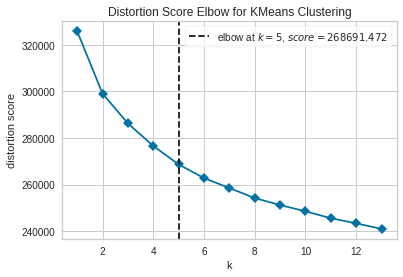

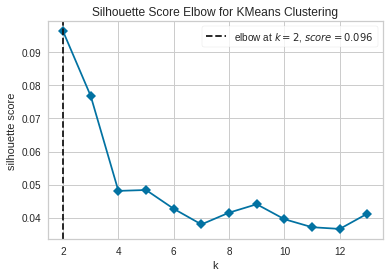

Centroid of cluster 0 = 0.1619156541910247
 
Centroid of cluster 1 = 0.15863611744541645
 
Centroid of cluster 2 = 0.1611018139764863
 
Centroid of cluster 3 = 0.17756959544285225
 
Cluster 0 Samples: Diabetes_binary
0.0    7253
1.0      68
dtype: int64 

Cluster 1 Samples: Diabetes_binary
0.0    9392
1.0     121
dtype: int64 

Cluster 2 Samples: Diabetes_binary
0.0    8300
1.0     104
dtype: int64 

Cluster 3 Samples: Diabetes_binary
0.0    3698
1.0      38
dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster 0 F1 Score:   0.00 +/- 0.00
Cluster 1 F1 Score:   0.00 +/- 0.00
Cluster 2 F1 Score:   0.00 +/- 0.00
Cluster 3 F1 Score:   0.00 +/- 0.00
Average F1 Score:   0.00 +/- 0.00


In [120]:
Stratified3(X_30, y_30)
Stratified3(X_31, y_31)
Stratified3(X_32, y_32)
Stratified3(X_33, y_33)